# Analyzing Sunshine Data

----

#### Summary
In this notebook I will be working on 'sunshine.csv'. This dataset contains sunshine duration by cities and countries, expressed in hours per year.I am interested in whether countries with longer sunshine hours will have lower suicide rates, since shorter sunshine duration is said to increase the risk of depression and depression is directly linked to suicide rates. 

#### Key Question
* Is there a relationship between sunshine hours and suicide rates? 

In [2]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import geopandas as gpd

suicide = pd.read_csv('../data/Cleaned_data/suicide_total.csv')
geo = gpd.read_file('../data/Others/countries.geojson')

In [3]:
tables=pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration")
len(tables)

7

In [4]:
sunshine=pd.concat(tables)
#sunshine.to_csv("../data/Raw_data/sunshine.csv",index=False)
sunshine

,0,1,Apr,Aug,City,Country,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Ref.,Sep,Year
0,NaN,This article may be too long to read and navig...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,188.0,80.0,Gagnoa,Ivory Coast,164.0,180.0,183.0,97.0,118.0,196.0,181.0,171.0,155.0,[2],110.0,1823.0
1,NaN,NaN,194.0,82.0,Bouaké,Ivory Coast,198.0,224.0,242.0,104.0,145.0,219.0,208.0,191.0,170.0,[2],115.0,2092.0
2,NaN,NaN,214.0,125.0,Abidjan,Ivory Coast,224.0,223.0,223.0,137.0,128.0,239.0,205.0,224.0,215.0,[2],139.0,2296.0
3,NaN,NaN,214.7,174.5,Odienné,Ivory Coast,242.6,220.2,242.0,183.5,221.8,217.3,248.8,252.0,235.8,[3],185.4,2638.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,NaN,NaN,155.6,149.0,Christchurch,New Zealand,214.3,190.5,224.4,124.8,117.7,177.4,133.3,215.3,201.3,?,166.6,2070.2
12,NaN,NaN,153.8,137.2,Wellington,New Zealand,222.9,205.0,240.3,111.4,102.3,194.7,126.0,210.8,191.1,?,163.2,2058.7
13,NaN,NaN,125.9,122.2,Dunedin,New Zealand,168.3,158.0,179.6,110.6,95.3,146.1,108.4,166.9,165.5,[180],136.8,1683.7
14,NaN,NaN,200.0,222.0,Port Moresby,Papua New Guinea,216.0,158.0,182.0,203.0,200.0,184.0,211.0,243.0,231.0,NaN,213.0,2463.0


#### Cleaning up data
* Dropped the first row because it does not contain any useful information and reset index 
* Dropped everything else except for Country and Year (sunshine duration per year), since I don't need the monthly information

In [5]:
sunshine = sunshine.drop(sunshine.index[0])
sunshine = sunshine.reset_index()
sunshine = sunshine.filter(["Country", "Year"], axis=1)
sunshine

,Country,Year
0,Ivory Coast,2092.0
1,Ivory Coast,2296.0
2,Ivory Coast,2638.6
3,Ivory Coast,2757.0
4,Benin,2345.2
...,...,...
350,New Zealand,2070.2
351,New Zealand,2058.7
352,New Zealand,1683.7
353,Papua New Guinea,2463.0


#### Cleaning up data 2
* Since there are 3 values per country (each representing a city), I decided to take the average of the 3 so that each country only has one value 
* Then I merged the data with countries geojson to create a map that represents sunshine duration by region

In [6]:
sunshine_unique=sunshine.groupby('Country')['Year'].mean().to_frame().reset_index()
sunshine_unique
sunshine_unique.to_csv("../data/Cleaned_data/sunshine_cleaned.csv",index=False)

In [7]:
geo['ADMIN']=geo['ADMIN'].replace(["United States of America"],'United States')
geo_merge = pd.merge(left=geo, right=sunshine_unique, left_on='ADMIN', right_on='Country')
geo_merge

,ADMIN,ISO_A3,geometry,Country,Year
0,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",Angola,2341.000000
1,Argentina,ARG,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...",Argentina,2159.320000
2,Armenia,ARM,"MULTIPOLYGON (((45.54717 40.62155, 45.51369 40...",Armenia,2474.000000
3,Australia,AUS,"MULTIPOLYGON (((158.86573 -54.74993, 158.83823...",Australia,2845.762500
4,Austria,AUT,"POLYGON ((15.16179 48.93722, 15.23807 48.95076...",Austria,1884.000000
...,...,...,...,...,...
125,Venezuela,VEN,"MULTIPOLYGON (((-61.39027 8.58058, -61.36986 8...",Venezuela,2895.550000
126,Vietnam,VNM,"MULTIPOLYGON (((106.66871 8.75349, 106.66586 8...",Vietnam,2123.500000
127,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",South Africa,3141.316667
128,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619...",Zambia,2965.466667


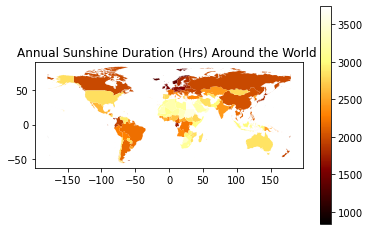

In [8]:
geo_merge.plot(column='Year', legend=True,cmap='afmhot')
plt.title("Annual Sunshine Duration (Hrs) Around the World ")
#plt.savefig('sunshine_duration.png',dpi=1200)


#### Examine relationships
* First I merged the sunshine data with the cleaned world suicide data and then ran it through a regression model
* Result shows that there is a statistically significant negative relationship between sunshine duration and suicide rate: the more sunshine a country gets, the lower suicide rate it has. This result matches my prediction. 

In [9]:
merged = pd.merge(left=sunshine_unique, right=suicide, left_on='Country', right_on='Country')
merged

,Country,Year,Sex,2016,2015,2010,2000,means
0,Algeria,3266.500000,Both sexes,3.3,3.4,3.5,4.7,3.833333
1,Angola,2341.000000,Both sexes,8.9,9.3,10.4,13.9,11.066667
2,Argentina,2159.320000,Both sexes,9.1,8.7,8.6,9.5,9.066667
3,Armenia,2474.000000,Both sexes,5.7,6.0,5.4,3.2,4.766667
4,Australia,2845.762500,Both sexes,11.7,12.2,11.0,12.2,11.633333
...,...,...,...,...,...,...,...,...
116,United States,2827.618519,Both sexes,13.7,13.3,11.8,10.1,11.866667
117,Uruguay,2481.400000,Both sexes,16.5,17.4,14.9,15.9,15.766667
118,Uzbekistan,2823.900000,Both sexes,7.4,7.4,6.0,9.1,7.500000
119,Zambia,2965.466667,Both sexes,11.3,11.2,11.5,14.1,12.300000


In [10]:
m1 = smf.ols(formula= 'means ~ Year', data=merged)
res = m1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  means   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     11.44
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           0.000975
Time:                        23:44:15   Log-Likelihood:                -391.12
No. Observations:                 121   AIC:                             786.2
Df Residuals:                     119   BIC:                             791.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.3840      2.423      8.001      0.0

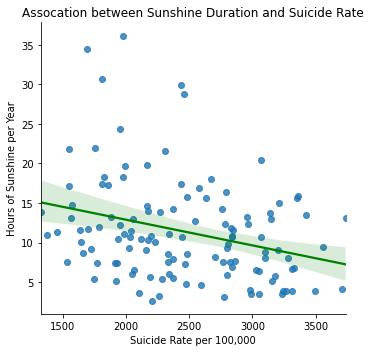

In [28]:
ax=sns.lmplot(x='Year', y='means', data=merged, line_kws={'color': 'green'})
ax.set(xlabel='Suicide Rate per 100,000', ylabel='Hours of Sunshine per Year')
plt.title('Assocation between Sunshine Duration and Suicide Rate')
plt.tight_layout()
#plt.savefig('sunshine_suicide.png',dpi=1200)
